In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls "/content/drive/My Drive/Deep Learning"

 1.jpg		        fashion-mnist_test.csv	  Untitled2.ipynb
 2.jpg		        fashion-mnist_train.csv   Untitled3.ipynb
 3.jpg		        Housing.CSV		  Untitled4.ipynb
'Assignment #4.ipynb'   Untitled		  Untitled5.ipynb
'Assignment #5.ipynb'   Untitled0.ipynb		  win2.xls
 cifar-10-batches-py    Untitled1.ipynb		  wine1.xls


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [6]:
data = pd.read_csv('/content/drive/My Drive/Deep Learning/fashion-mnist_test.csv')
data.head(3)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,0,0,34,29,7,0,11,24,0,0,3,3,1,0,1,1,0,0,0,0,0,4,0,0,1,0,0,0,0,0,...,242,245,224,245,234,0,3,0,0,0,0,0,0,0,0,0,0,0,0,37,69,94,123,127,138,138,142,145,135,125,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,209,190,181,150,170,193,180,219,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,...,248,238,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,174,233,155,0,65,235,216,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,17,0,0,0,0,0,0,0,0,12,94,68,14,0,0,0,0,0,0,0,0,0,0,0,38,106,94,89,94,68,...,0,0,0,0,0,0,87,12,26,0,0,0,0,0,0,0,46,50,29,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,63,53,31,0,0,0


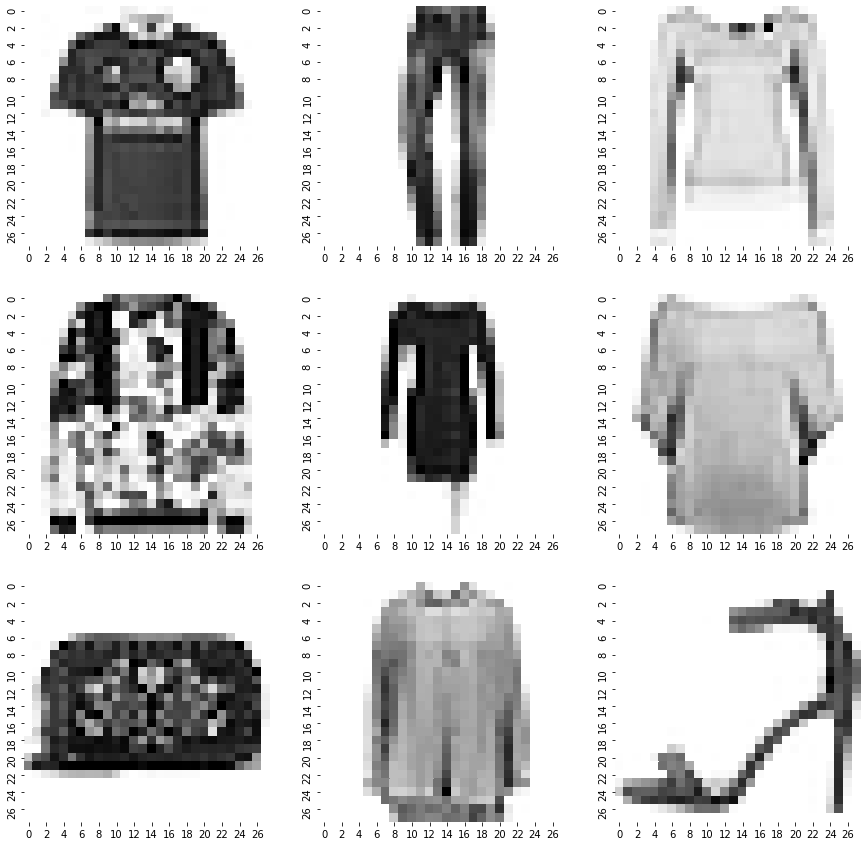

In [7]:
fig = plt.figure(figsize=(15,15))
for i in range(1,10):
    fig.add_subplot(3,3,i)
    sns.heatmap(np.array(data.iloc[i-1,1:]).reshape(28,28), cbar=False, cmap='Greys');

In [8]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [9]:
mean = np.array(data.iloc[:,1:]).flatten().mean()
std = np.array(data.iloc[:,1:]).flatten().std()
print('mean = ', mean)
print('std = ', std)

mean =  73.16080497448979
std =  90.27313431260943


In [10]:
class Fashion(Dataset):
    def __init__(self, data, transform=None):
        self.transform = transform
        dataset = data
        self.labels = dataset.label.values
        self.images = dataset.iloc[:, 1:].values.astype('uint8').reshape(-1, 28, 28)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        return img, label

In [12]:
transf = transforms.Compose([transforms.ToTensor(), 
                            transforms.Normalize( (mean/225,), (std/225,) )])

data_train = Fashion(pd.read_csv('/content/drive/My Drive/Deep Learning/fashion-mnist_train.csv'),transform=transf)
data_test = Fashion(pd.read_csv('/content/drive/My Drive/Deep Learning/fashion-mnist_test.csv'),transform=transf)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=64, shuffle=True)

In [13]:
class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], hidden_size[2])
        self.fc4 = nn.Linear(hidden_size[2], num_classes)
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.tanh(out)
        out = self.fc3(out)
        out = self.tanh(out)
        out = self.fc4(out)
        return out

In [14]:
params = []
loss_train = []
loss_test = []

def test(model):
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        correct = 0
        total = 0
        for batch_id, (image, label) in enumerate(test_loader):
            image = image.view(image.shape[0],-1)
            outputs = model(image)
            
            # add loss to graph
            if (batch_id % 100 == 0) & (batch_id > 0):
                loss = criterion(outputs, label)
                loss_test.append(loss.item())
            predicted = torch.argmax(outputs,dim=1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
        print('Test accuracy: {} %'.format(100 * correct / total))
        
def train():
    model = Net(784, [150,150,150], 10)
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(1, 20):
        for batch_id, (image, label) in enumerate(train_loader):
            image = image.view(image.shape[0],-1)
            output = model(image)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_id % 1024 == 0:
                print('Loss :{:.4f} Epoch - {}/{} '.format(loss.item(), epoch, 20), end=' ')
                loss_train.append(loss.item())
        test(model)
    for i in model.parameters():
        params.append(i)
    return model

In [15]:
model = train()

Loss :2.3092 Epoch - 1/20  Test accuracy: 84.01 %
Loss :0.5357 Epoch - 2/20  Test accuracy: 85.31 %
Loss :0.3534 Epoch - 3/20  Test accuracy: 86.18 %
Loss :0.3880 Epoch - 4/20  Test accuracy: 86.74 %
Loss :0.2265 Epoch - 5/20  Test accuracy: 87.56 %
Loss :0.2872 Epoch - 6/20  Test accuracy: 87.7 %
Loss :0.4910 Epoch - 7/20  Test accuracy: 87.97 %
Loss :0.2397 Epoch - 8/20  Test accuracy: 87.93 %
Loss :0.4197 Epoch - 9/20  Test accuracy: 88.62 %
Loss :0.3010 Epoch - 10/20  Test accuracy: 88.45 %
Loss :0.2747 Epoch - 11/20  Test accuracy: 88.68 %
Loss :0.1835 Epoch - 12/20  Test accuracy: 88.63 %
Loss :0.2363 Epoch - 13/20  Test accuracy: 88.78 %
Loss :0.2135 Epoch - 14/20  Test accuracy: 89.13 %
Loss :0.1438 Epoch - 15/20  Test accuracy: 89.11 %
Loss :0.3306 Epoch - 16/20  Test accuracy: 89.08 %
Loss :0.1771 Epoch - 17/20  Test accuracy: 89.42 %
Loss :0.2802 Epoch - 18/20  Test accuracy: 88.91 %
Loss :0.2749 Epoch - 19/20  Test accuracy: 89.05 %


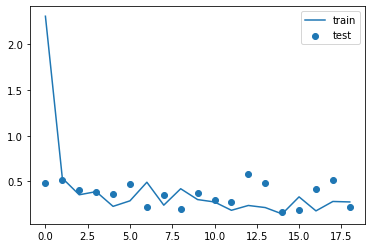

In [16]:
plt.plot(np.arange(19),loss_train, label='train')
plt.scatter(np.arange(19),loss_test, label = 'test')
plt.legend();